In [40]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE, SelectFromModel
import optuna.integration.sklearn

In [2]:
all_new = pd.read_csv('data/feature_df.csv')
wordvec_df = pd.read_csv('sub_notebook/data/wordvectorized_df.csv')
#bert_embeded = pd.read_csv('data/bert_embeded.csv')
bert_embeded = pd.read_csv('data/bert_svd256.csv')
tfidf_svd_raw_64 = pd.read_csv("data/tfidf_svd_raw_64.csv")
mfw_df = pd.read_csv('data/mfw.csv')
miw_df = pd.read_csv('data/miw.csv')

In [3]:
all_new = pd.merge(all_new, bert_embeded, on="id", how="outer")
all_new = pd.merge(all_new, tfidf_svd_raw_64, on="id", how="outer")
all_new = pd.merge(all_new, wordvec_df, on="id", how="outer")
all_new = pd.merge(all_new, miw_df, on="id", how="outer")
all_new = pd.merge(all_new, mfw_df.drop(["mfw", "sfw"], axis=1), on="id", how="outer")

In [4]:
test_set = all_new[all_new["data_type"] == "test"]
train_set= all_new[all_new["data_type"] == "train"]

In [5]:
def run_optuna_random_forest(test, train, target_cols, feature_cols):
    """
    import optuna.integration.sklearn
    """
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    
    X_train = train[feature_cols]
    y_train = train[target_cols]
    X_test = test[feature_cols]
    
    imp_train = imp.fit(X_train)
    imp_test = imp.fit(X_test)
    X_train = pd.DataFrame(imp_train.transform(X_train))
    X_test = pd.DataFrame(imp_test.transform(X_test))
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(X_train),))
    importances = []
    
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
        X_tr = X_train.loc[train_index]
        X_val = X_train.loc[valid_index]
        y_tr = y_train.loc[train_index].values.ravel()
        y_val = y_train.loc[valid_index].values.ravel()

        clf = RandomForestClassifier(n_jobs=4)
        param_distributions = {"n_estimators": optuna.distributions.IntUniformDistribution(50, 1000, step=10),
                               "max_depth": optuna.distributions.IntUniformDistribution(4, 50),
                               'min_samples_split': optuna.distributions.UniformDistribution(0.0001, 1.0),
                               'min_samples_leaf': optuna.distributions.IntUniformDistribution(1, 60),
                              }
        optuna_search = optuna.integration.OptunaSearchCV(clf,
                                                          param_distributions,
                                                          n_jobs=4,
                                                          n_trials=50,
                                                          )
        optuna_search.fit(X_tr, y_tr)
        
        oof_train[valid_index] = optuna_search.predict_proba(X_val)[:,1]
        y_pred = optuna_search.predict_proba(X_test)[:,1]

        y_preds.append(y_pred)
        models.append(optuna_search)
        
        # display importance
        importance = pd.DataFrame(optuna_search.best_estimator_.feature_importances_, index=feature_cols, columns=['importance'])
        display(importance)
        importances.append(importance)

    return oof_train, sum(y_preds) / len(y_preds), importances

In [6]:
with open("data/lgbm_config_bert256_svd64_raw.json") as f:
    optuna_config_dict = json.load(f)

target_cols = ["state"]
#feature_cols = optuna_config_dict["selected_feature"]

feature_cols = list(all_new.columns.drop(["id", "state","data_type"]))

In [7]:
def optuna_feature_selection(test, train, target_cols, feature_cols):
    X_train = train[feature_cols]
    y_train = train[target_cols].values.ravel()
    X_test = test[feature_cols]
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp_train = imp.fit(X_train)
    imp_test = imp.fit(X_test)
    X_train = pd.DataFrame(imp_train.transform(X_train))
    X_test = pd.DataFrame(imp_test.transform(X_test))
    
    
    estimator = RandomForestClassifier(n_estimators=200,
                                       max_depth=40,
                                       min_samples_split=2,
                                       min_samples_leaf=30,
                                       n_jobs=4)
    selector = RFE(estimator,
                   step=0.1,
                  verbose=True)
    
    param_distributions = {"n_features_to_select": optuna.distributions.IntUniformDistribution(100, 500)}
    optuna_search = optuna.integration.OptunaSearchCV(selector,
                                                      param_distributions,
                                                      n_jobs=1,
                                                      n_trials=50,
                                                      )
    optuna_search.fit(X_train, y_train)
    
    return optuna_search.best_estimator_.n_features_, optuna_search.best_estimator_.ranking_

In [41]:
def rfe_feature_selection(test, train, target_cols, feature_cols):
    X_train = train[feature_cols]
    y_train = train[target_cols].values.ravel()
    X_test = test[feature_cols]
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp_train = imp.fit(X_train)
    imp_test = imp.fit(X_test)
    X_train = pd.DataFrame(imp_train.transform(X_train))
    X_test = pd.DataFrame(imp_test.transform(X_test))
    
    """
        estimator = RandomForestClassifier(n_estimators=200,
                                       max_depth=40,
                                       min_samples_split=2,
                                       min_samples_leaf=30,
                                       n_jobs=4)
            selector = RFE(estimator,
                   step=0.2,
                  verbose=True,
                  n_features_to_select=300,
                  )
    """
    
    estimator = GradientBoostingClassifier()
    selector = SelectFromModel(estimator)

    
    selector.fit(X_train, y_train)
    #print(selector.score(X_train, y_train))
    
    feature_arr = np.array(feature_cols)
    return list(feature_arr[selector.get_support()])

In [42]:
features = rfe_feature_selection(test_set, train_set, target_cols, feature_cols)

In [43]:
features

['number_of_<img>',
 'number_of_</a>',
 'number_of_<h1>',
 'number_of_</i>',
 'duration/bins_duration',
 'duration/number_of_chars',
 'duration/number_of_excmark',
 'duration+number_of_questmark',
 'duration/number_of_questmark',
 'duration/number_of_punctuation',
 'duration+number_of_symbols',
 'duration/number_of_symbols',
 'duration/number_of_unique_words',
 'duration+number_of_<span>',
 'duration/number_of_<span>',
 'duration+number_of_<p>',
 'duration/number_of_<p>',
 'duration/number_of_<iframe>',
 'duration+number_of_<img>',
 'duration/number_of_<img>',
 'duration/number_of_<a>',
 'duration+number_of_<figure>',
 'goal_min+number_of_chars',
 'goal_min/number_of_chars',
 'goal_min/number_of_sentences',
 'goal_min+number_of_excmark',
 'goal_min/number_of_excmark',
 'goal_min/number_of_questmark',
 'goal_min/number_of_punctuation',
 'goal_min/number_of_symbols',
 'goal_min/number_of_unique_words',
 'goal_min/number_of_<span>',
 'goal_min/number_of_<p>',
 'goal_min/number_of_<div>',


In [28]:
#n_features, ranking = optuna_feature_selection(test_set, train_set, target_cols, feature_cols)

In [29]:
oof, preds, importances = run_optuna_random_forest(test_set, train_set, target_cols, feature_cols)

<ipython-input-5-10cdff432c44>:34: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(clf,
/home/teppei/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classifier=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[I 2021-01-29 00:22:49,653] A new study created in memory with name: no-name-00ff0af7-6b35-46ba-8c61-cef24c411a48
[I 2021-01-29 00:23:15,147] Trial 1 finished with value: 0.503082043617628 and parameters: {'n_estimators': 620, 'max_depth': 7, 'min_samples_split': 0.7460482079288999, 'min_samples_leaf': 20}. Best is trial 1 with value: 0.503082043617628.
[I 2021-01-29 00:23:15,195] Trial 2 finished with value: 0.6949993959944601 and parameters: {'n_estimators': 270, 'max_depth': 44, 'min_samples_split': 0.47

KeyboardInterrupt: 

[I 2021-01-29 00:23:48,800] Trial 5 finished with value: 0.503082043617628 and parameters: {'n_estimators': 810, 'max_depth': 36, 'min_samples_split': 0.6814829060415577, 'min_samples_leaf': 50}. Best is trial 4 with value: 0.6967772792781151.
[I 2021-01-29 00:23:52,658] Trial 0 finished with value: 0.7517800605129271 and parameters: {'n_estimators': 340, 'max_depth': 13, 'min_samples_split': 0.10975632308738922, 'min_samples_leaf': 45}. Best is trial 0 with value: 0.7517800605129271.
[I 2021-01-29 00:24:03,519] Trial 3 finished with value: 0.7149135288812976 and parameters: {'n_estimators': 710, 'max_depth': 34, 'min_samples_split': 0.3065267393042494, 'min_samples_leaf': 47}. Best is trial 0 with value: 0.7517800605129271.


In [34]:
def optimize_threshold(oof, y_train):
    best_score = 0
    scores = []
    ratios = []
    for thr in np.arange(0, 1.0, 0.025):
        oof_ = np.where(oof<thr, 0, 1)
        ratio = np.count_nonzero(oof_>0)/len(oof_)
        ratios.append(ratio)
        f1score = f1_score(y_true=y_train, y_pred=oof_,average='binary', sample_weight=None, zero_division='warn')
        scores.append(f1score)
        best_score = max(best_score, f1score)
        if f1score == best_score:
            best_threshold = thr
    plt.figure()
    plt.title('f1_score')
    plt.scatter(np.arange(0, 1.0, 0.025), scores)
    plt.scatter(np.arange(0, 1.0, 0.025), ratios)
    return best_score, best_threshold

0.7856130403968817 0.47500000000000003


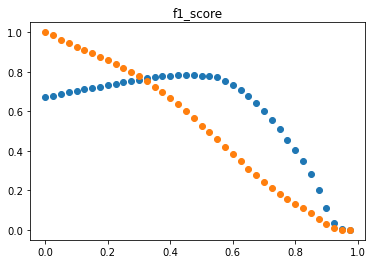

In [35]:
best_score, best_threshold = optimize_threshold(oof, list(train_set["state"]))
print(best_score, best_threshold)

In [37]:
config_dict = {
    "selected_feature": feature_cols,
    "out_of_fold": list(oof),
    "prediction": list(preds),
}

In [38]:
with open("data/rf_config_bert256_svd64_raw.json", 'w') as f:
    json.dump(config_dict, f)